In [1]:
import earthaccess
import rioxarray
import rasterio
import xarray as xr
import numpy as np
from timebudget import timebudget

In [2]:
results = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    temporal=("2020-01-01", "2021-12-31"),
    #temporal=("2019-01-01", "2019-01-31"),
)


Granules found: 729


In [3]:
%%time
files = earthaccess.open(results)
ds = xr.open_mfdataset(files,
                       decode_times=False, 
                       data_vars=['analysed_sst', 'sea_ice_fraction'], 
                       concat_dim="time", 
                       combine="nested",
                       parallel=True)


Opening 729 granules, approx size: 505.34 GB


QUEUEING TASKS | :   0%|          | 0/729 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/729 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/729 [00:00<?, ?it/s]

CPU times: user 2min 12s, sys: 35.9 s, total: 2min 48s
Wall time: 29min 35s


In [4]:
%%time
dds = ds.sel(lon=slice(-93, -76), lat=slice(41, 49))
cond = (dds.sea_ice_fraction < 0.15) | np.isnan(dds.sea_ice_fraction)
result = dds.analysed_sst.where(cond)

CPU times: user 21.3 ms, sys: 0 ns, total: 21.3 ms
Wall time: 19.4 ms


/home/jovyan/.virtualenvs/spatial/lib/python3.10/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


CPU times: user 3min 51s, sys: 1min 28s, total: 5min 19s
Wall time: 46min 19s


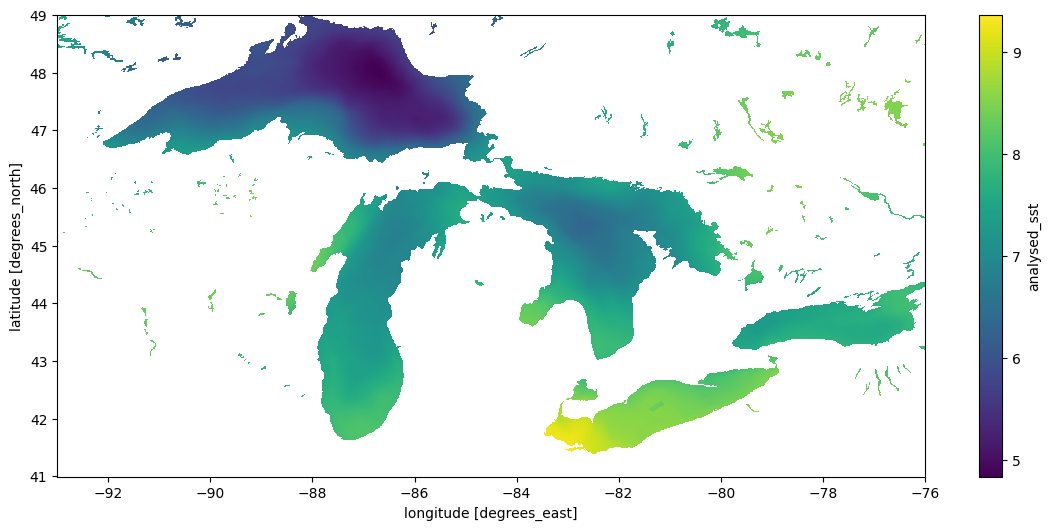

In [5]:
%%time
result.std("time").plot(figsize=(14, 6), x="lon", y="lat")

# Using GDAL-based parsing

In [8]:
%%time
import warnings
warnings.filterwarnings('ignore')
import os
from pathlib import Path
cookies = os.path.expanduser("~/.urs_cookies")
Path(cookies).touch()

## pull out the URLs
data_links = [granule.data_links(access="external") for granule in results]
url_links = [f'{link[0]}' for link in data_links]


# and here we go
with rasterio.Env(GDAL_INGESTED_BYTES_AT_OPEN="32000",
                  GDAL_HTTP_MULTIPLEX="YES",
                  GDAL_HTTP_MERGE_CONSECUTIVE_RANGES="YES",
                  GDAL_HTTP_VERSION="2",
                  GDAL_NUM_THREADS="ALL_CPUS",
                  GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
                  GDAL_HTTP_COOKIEFILE=cookies, 
                  GDAL_HTTP_COOKIEJAR=cookies, 
                  GDAL_HTTP_NETRC=True):
    ds1 = xr.open_mfdataset(url_links, 
                           engine = "rasterio", 
                           concat_dim="time", 
                           combine="nested",
                           )

CPU times: user 47.7 s, sys: 3.78 s, total: 51.4 s
Wall time: 11min 48s


In [ ]:
%%time
dds = ds1.sel(x=slice(18000-9300, 18000-7600), y = slice(9000+4100,9000+4900))
dds.analysed_sst.std("time").plot(figsize=(14, 6), x="x", y="y")
